In [ ]:
!pip install torchsummary

In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
normal = np.load('/content/drive/MyDrive/데이터/파/train/파_정상_224_color.npy')
disease = np.load('/content/drive/MyDrive/데이터/파/train/파_질병_224_color.npy')
expend = np.load('/content/drive/MyDrive/데이터/파/train/파_증강_224_color.npy')
diseases = np.concatenate((disease, expend), axis=0)
X_train2 = np.concatenate((normal, diseases), axis=0)
labels = pd.read_csv('/content/drive/MyDrive/데이터/파/train/[라벨]파.csv')
if X_train2.shape[0]==labels.shape[0] :
    y_train = labels.loc[:,'disease']
else :
    print('길이가 같지 않습니다.')

In [ ]:
np.unique(y_train)

array([ 0., 16., 17., 18.])

In [ ]:
y_train[y_train==16]=1
y_train[y_train==17]=2
y_train[y_train==18]=3

<ipython-input-26-725e9f02fb39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[y_train==16]=1
<ipython-input-26-725e9f02fb39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[y_train==17]=2
<ipython-input-26-725e9f02fb39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[y_train==18]=3


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X_train2, y_train, test_size=0.2, random_state=42, stratify = y_train)


y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36195, 224, 224, 3) (9049, 224, 224, 3) (36195, 4) (9049,)


In [ ]:
# 용량 제한 맞춘 수정본
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, Input, Activation, ZeroPadding2D

def input_layer(x):
    x = ZeroPadding2D(padding=(3, 3))(x)  # 230x230x3
    x = Conv2D(64, (7, 7), strides=(2, 2))(x) # 112x112x64
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1,1))(x) # 114x114x64
    x = MaxPooling2D((3, 3), 2)(x) # 56 x 56 x 64
    return x

def conv_layer1(x, out,layer):
    shortcut = x

    for i in range(layer):
        x = Conv2D(out, (3, 3), strides=(1, 1), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)
        shortcut = x
    return x

def conv_layer2(x, out, layer):

    for i in range(layer):
        if(i == 0):
            x = Conv2D(out, (1, 1), strides=(2, 2), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            shortcut=x

        else:
            x = Conv2D(out, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x = Add()([x, shortcut])
            x = Activation('relu')(x)

            shortcut = x

    return x


def resnet_light():
    inputs = Input(shape=(224, 224, 3))

    x = input_layer(inputs)   # 56x56x64
    x = conv_layer1(x,64,3)   # 56x56x64
    x = conv_layer2(x,128,4)  # 28x28x128
    x = conv_layer2(x,256,5)  # 14x14x256
    x = conv_layer2(x,512,3)  # 7x7x512

    x = GlobalAveragePooling2D()(x)  # 512
    x = Dense(1000)(x)
    output_tensor = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=output_tensor)
    return model

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Recall
model = resnet_light()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Recall()])


modelpath='/content/drive/MyDrive/작물별 모델/파/green_onion_model.keras'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=40)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=32, verbose=0, callbacks=[early_stopping_callback,checkpointer])

loaded_model = load_model(modelpath)

loss, accuracy, recall = loaded_model.evaluate(X_test, y_test)
print("\n Test Accuracy: %.4f" % accuracy)
print("\n Test Recall: %.4f" % recall)


Epoch 1: val_loss improved from inf to 1.09521, saving model to /content/drive/MyDrive/작물별 모델/파/green_onion_model.keras

Epoch 2: val_loss improved from 1.09521 to 0.60271, saving model to /content/drive/MyDrive/작물별 모델/파/green_onion_model.keras

Epoch 3: val_loss did not improve from 0.60271

Epoch 4: val_loss did not improve from 0.60271

Epoch 5: val_loss improved from 0.60271 to 0.25851, saving model to /content/drive/MyDrive/작물별 모델/파/green_onion_model.keras

Epoch 6: val_loss did not improve from 0.25851

Epoch 7: val_loss improved from 0.25851 to 0.24939, saving model to /content/drive/MyDrive/작물별 모델/파/green_onion_model.keras

Epoch 8: val_loss did not improve from 0.24939

Epoch 9: val_loss improved from 0.24939 to 0.19534, saving model to /content/drive/MyDrive/작물별 모델/파/green_onion_model.keras

Epoch 10: val_loss did not improve from 0.19534

Epoch 11: val_loss improved from 0.19534 to 0.14085, saving model to /content/drive/MyDrive/

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import load_model
modelpath='/content/drive/MyDrive/작물별 모델/파/green_onion_model.keras'
loaded_model = load_model(modelpath)

loss, accuracy, recall = loaded_model.evaluate(X_test, y_test)
print("\n Test Accuracy: %.4f" % accuracy)
print("\n Test Recall: %.4f" % recall)

283/283 [==============================] - 4s 13ms/step - loss: 0.0832 - accuracy: 0.9801 - recall_2: 0.9800

 Test Accuracy: 0.9801

 Test Recall: 0.9800


In [ ]:
from tensorflow.keras.models import load_model
modelpath='/content/drive/MyDrive/작물별 모델/파/green_onion_model_224_18layer_color'
loaded_model = load_model(modelpath)

print("\n Test Accuracy: %.4f" % (loaded_model.evaluate(X_val, y_val)[1]))

283/283 [==============================] - 3s 8ms/step - loss: 0.1204 - accuracy: 0.9651 - recall_1: 0.9641

 Test Accuracy: 0.9651


In [ ]:
import os,sys
from PIL import Image
def resize_and_crop(img_array,size, crop_type='middle'):
    img = Image.fromarray(image_array)
    img_ratio = img.size[0] / float(img.size[1])
    ratio = size[0] / float(size[1])

    if ratio > img_ratio:
        img = img.resize((size[0], int(round(size[0] * img.size[1] / img.size[0]))),
            Image.LANCZOS)
        if crop_type == 'top':
            box = (0, 0, img.size[0], size[1])
        elif crop_type == 'middle':
            box = (0, int(round((img.size[1] - size[1]) / 2)), img.size[0],
                int(round((img.size[1] + size[1]) / 2)))
        elif crop_type == 'bottom':
            box = (0, img.size[1] - size[1], img.size[0], img.size[1])
        else :
            raise ValueError('ERROR: invalid value for crop_type')
        img = img.crop(box)

    elif ratio < img_ratio:
        img = img.resize((int(round(size[1] * img.size[0] / img.size[1])), size[1]),
            Image.LANCZOS)
        if crop_type == 'top':
            box = (0, 0, size[0], img.size[1])
        elif crop_type == 'middle':
            box = (int(round((img.size[0] - size[0]) / 2)), 0,
                int(round((img.size[0] + size[0]) / 2)), img.size[1])
        elif crop_type == 'bottom':
            box = (img.size[0] - size[0], 0, img.size[0], img.size[1])
        else :
            raise ValueError('ERROR: invalid value for crop_type')
        img = img.crop(box)

    else :
        img = img.resize((size[0], size[1]), Image.LANCZOS)

    return img

In [ ]:
!pip install Pillow

In [ ]:
image = Image.open('/content/KakaoTalk_20231227_120513713.jpg')
# 이미지를 numpy 배열로 변환
image_array = np.array(image)
output_size = (224, 224)
resized_img = resize_and_crop(image_array,output_size, crop_type='middle')
test = np.array(resized_img).reshape(224,224,3)
img = test
height = img.shape[0]
width = img.shape[1]
#create target array for gray scale
gray_image = np.zeros((height, width, 1), dtype=np.uint8)

# 입력 이미지의 pixel 값 하나씩 불러서 변경
for h in range(height):
    for w in range(width):
        b = img[h, w, 0].astype(np.float32) # RGB의 Blue 값 입력받기
        g = img[h, w, 1].astype(np.float32) # RGB의 Green 값 입력받기
        r = img[h, w, 2].astype(np.float32) # RGB의 Red 값 입력받기

        intensity = (b+g+r)/3               # RGB 채널의 값을 하나의 값으로 평균 내기
        gray_image[h, w, 0] = intensity     # target array에 값 저장
gray_image = gray_image.reshape(1,128,128,1)
loaded_model.predict(gray_image)

1/1 [==============================] - 3s 3s/step


array([[1., 0., 0.]], dtype=float32)

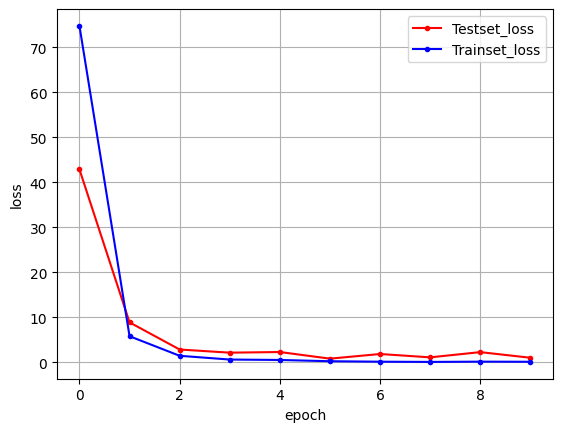

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']


x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')


plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()